In [17]:
import numpy as np
import matplotlib.pylab as pl
import os
import h5py

## define parameters

In [24]:
N=10
K=8
M_sys=1
M_train=1
P=1000000
T=int(1e4)
epochs=200
data_seed=1

store

In [3]:
hashlist_filename = f"../hashlist_N_{N}_K_{K}_Msys_{M_sys}_T_{T}_P_{int(P)}_Mtrain_{M_train}_Ep_{epochs}_dataseed_{data_seed}.npy"
hash_lists=np.load(hashlist_filename,allow_pickle=True).item()
hash_list_keys=[
    'bitpop_data',
    'simple_train',
    'simple_data',
    'match_train',
    'match_data'
]

FileNotFoundError: [Errno 2] No such file or directory: '../hashlist_N_10_K_8_Msys_1_T_10000_P_1000000_Mtrain_1_Ep_200_dataseed_1.npy'

## Plot action-action correlations

In [30]:
def get_action_data(hashh, get_pref_actions=False,data_seed=0):
    outdir = '../output'
    # data_dir =f'data_{hashh}'
    data_dir =hashh

    data_filename = os.path.join(outdir, data_dir, 'data.h5')
    # load the hdf data
    with h5py.File(data_filename, 'r') as f:
        datasets = {}
        for group_name, group in f.items():
            datasets[group_name] = {key: np.array(
                value) for key, value in group.items()}
    print(datasets.keys())
    data = datasets[f"train_dataset_{data_seed}"]
    states = data["states"]
    actions = data["actions"]
    if get_pref_actions:
        preferred_actions = data["preferred_actions"]
        return actions,preferred_actions
    else:
        return actions
def get_corr_matrix(data_matrix):
    n_samples,n_agents = data_matrix.shape
    corr_matrix = np.zeros([n_agents] * 2)
    for i in range(n_agents):
        for j in range(n_agents):
            if i < j:
                corr_matrix[i, j] = 2 * \
                    np.mean(data_matrix[:,i] == data_matrix[:,j]) - 1    
    return corr_matrix + corr_matrix.T + np.identity(n_agents)

In [25]:
for data_seed in [1]:
    # hashlist_filename = f"../hashlist_N_{N}_K_{K}_Msys_{M_sys}_T_{T}_P_{int(P)}_Mtrain_{M_train}_Ep_{epochs}_dataseed_{data_seed}.npy"
    # hash_lists=np.load(hashlist_filename,allow_pickle=True).item()
    # hash_list_keys=[
    #     'bitpop_data',
    #     'simple_train',
    #     'simple_data',
    #     'match_train',
    #     'match_data'
    # ]

    corrvec=[0,0.2,0.4,0.6,0.8,1.0]
    net_names = ['bitpop','simple']#,'match']
    corr_matrices={}
    for net_name in net_names:
        hash_list=hash_lists[net_name+'_data']
        corr_matrices[net_name]={}
        for corr,hashh in zip(corrvec,hash_list):
            if net_name=='bitpop':
                actions,pref_actions=get_action_data(hashh,get_pref_actions=True,data_seed=data_seed)
            else:
                actions= get_action_data(hashh)

            actions = (actions==pref_actions[np.newaxis,:])
            corr_matrices[net_name][corr]=get_corr_matrix(actions)
            
    # fig, ax = pl.subplots(len(net_names), len(corrvec), figsize=(3*len(net_names), 3*len(corrvec)))
    fig, ax = pl.subplots(2, len(corrvec), figsize=(3*(len(corrvec)),3*2))
    figt,axt=pl.subplots(2,2,figsize=(6,6))
    figs,axs=pl.subplots()
    colors=pl.cm.get_cmap('viridis')(np.linspace(0,1,len(corrvec)))
    net_data={}
    for nit,net_name in enumerate(net_names):
        
        df=pd.DataFrame(columns=('pcorr','rho'))
        nbins=41
        count_store=np.zeros((len(corrvec),nbins-1))
        means=[]
        stds=[]
        for rit, rho in enumerate(corrvec):
            cmtr=corr_matrices[net_name][rho]
            ax[0, rit].set_title(f"rho={rho}")
            ax[nit, rit].imshow(cmtr,vmin=0,vmax=1)
            mask=np.tril(np.ones(cmtr.shape,dtype=bool))
            means.append(np.mean(cmtr[mask]))
            stds.append(np.std(cmtr[mask]))
            counts, bins =np.histogram(cmtr[mask],bins=np.linspace(-1,1,nbins))
            count_store[rit,:]=counts
            axt[nit,0].bar(bins[:-1],count_store[rit,:],width=0.1,color=colors[rit])
        axt[nit,1].fill_between(x=corrvec,y1=np.array(means)+np.array(stds),y2=np.array(means)-np.array(stds),color='lightgray')
        axt[nit,1].plot(corrvec,means,'k-')
        for rit,corr in enumerate(corrvec):
            axt[nit,1].plot([corr],[means[rit]],'ko',mfc=colors[rit],clip_on=False,zorder=4)
        net_data[net_name]=means
        axt[nit,1].set_ylabel('avg. measured correlation')
        axt[nit,1].plot([0,1],[0,1],'k--')
    #     sns.lineplot(data=df,ax=axt, x='pcorr',y='rho',errorbar='sd')
    #     axt[nit,0].set_xlim(-0.2,1)
        axt[nit,1].set_ylim(0,1)
        axt[nit,1].set_xlim(0,1)
        


        ax[nit, 0].set_ylabel(net_name)
    axs.plot(net_data['bitpop'],net_data['simple'],'o-')
    axs.plot([0,1],[0,1],'k--')

    axt[1,1].set_xlabel('correlation parameter')
    axt[1,0].set_xlabel('measured correlation')
    axt[0,0].set_ylabel('count')
    axt[1,0].set_ylabel('count')
    axt[0,0].text(.1, .9, 'bitpop', ha='left', va='top', transform=axt[0,0].transAxes)
    axt[1,0].text(.1, .9, 'simpletask', ha='left', va='top', transform=axt[1,0].transAxes)

    fig.tight_layout()
    figt.tight_layout()
    # axt.set_ylim(0,1)

FileNotFoundError: [Errno 2] No such file or directory: '../hashlist_N_10_K_8_Msys_1_T_10000_P_1000000_Mtrain_1_Ep_200_dataseed_1.npy'

In [35]:
import seaborn as sns
import pandas as pd

## Generate data with new code

In [50]:
import os
os.chdir('../')
from data_utils import gen_logit_dataset

In [45]:
#variation
wstates = [0., 1., 10.]
corrs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [10]:
dataset_config = {
    "num_train_samples": 10000,
    "num_test_samples": 2,
    "outdir" : "output/",
    "num_actions": 2,
    "num_agents": 10,
    "state_dim": 7,
    "model_name":"logit",
    "corr": 1.0,
    "state_weight": 1.0
}

In [51]:
data_dir_store = {}
for wstate in wstates:
    data_dir_store[wstate]={}
    for corr in corrs:
        dataset_config['state_weight'] = wstate
        dataset_config['corr'] = corr
        data_dir_store[wstate][corr]=gen_logit_dataset(dataset_config)

running seed 0 of 2
running seed 1 of 2
saving data_ab5d83fbd0
running seed 0 of 2
running seed 1 of 2
saving data_db8b584f31
running seed 0 of 2
running seed 1 of 2
saving data_5fa8ef1d07
running seed 0 of 2
running seed 1 of 2
saving data_8869565511
running seed 0 of 2
running seed 1 of 2
saving data_04c59715db
running seed 0 of 2
running seed 1 of 2
saving data_d5a1ea3ae8
running seed 0 of 2
running seed 1 of 2
saving data_ce1e8a4f8b
running seed 0 of 2
running seed 1 of 2
saving data_14f562e952
running seed 0 of 2
running seed 1 of 2
saving data_51bb554c2e
running seed 0 of 2
running seed 1 of 2
saving data_071377d371
running seed 0 of 2
running seed 1 of 2
saving data_2e3110406f
running seed 0 of 2
running seed 1 of 2
saving data_9c4f24b3c6
running seed 0 of 2
running seed 1 of 2
saving data_01e3d710fb
running seed 0 of 2
running seed 1 of 2
saving data_3019e08533
running seed 0 of 2
running seed 1 of 2
saving data_170353fac8
running seed 0 of 2
running seed 1 of 2
saving data_07f

In [63]:
data_dir_store[wstate].keys()

dict_keys([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

In [27]:
datasets

NameError: name 'datasets' is not defined

In [47]:
corr_matrices.keys()

dict_keys([0.0, 1.0, 10.0])

In [53]:
os.chdir('notebooks/')


In [55]:
list(corr_matrices[0.].keys())

[1.0]

In [33]:
import pandas as pd

In [48]:
corrs

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [58]:
corr_matrices[wstate][0.0]

KeyError: 0.0

In [59]:
corr_matrices[wstate].keys()

dict_keys([1.0])

In [60]:
corrs

[0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

In [62]:
list(corr_matrices[0.].keys())

[1.0]

dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_dataset_0', 'train_dataset_1'])
dict_keys(['test_dataset_0', 'test_dataset_1', 'train_

/tmp/ipykernel_4316/961137760.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=pl.cm.get_cmap('viridis')(np.linspace(0,1,len(corrs)))


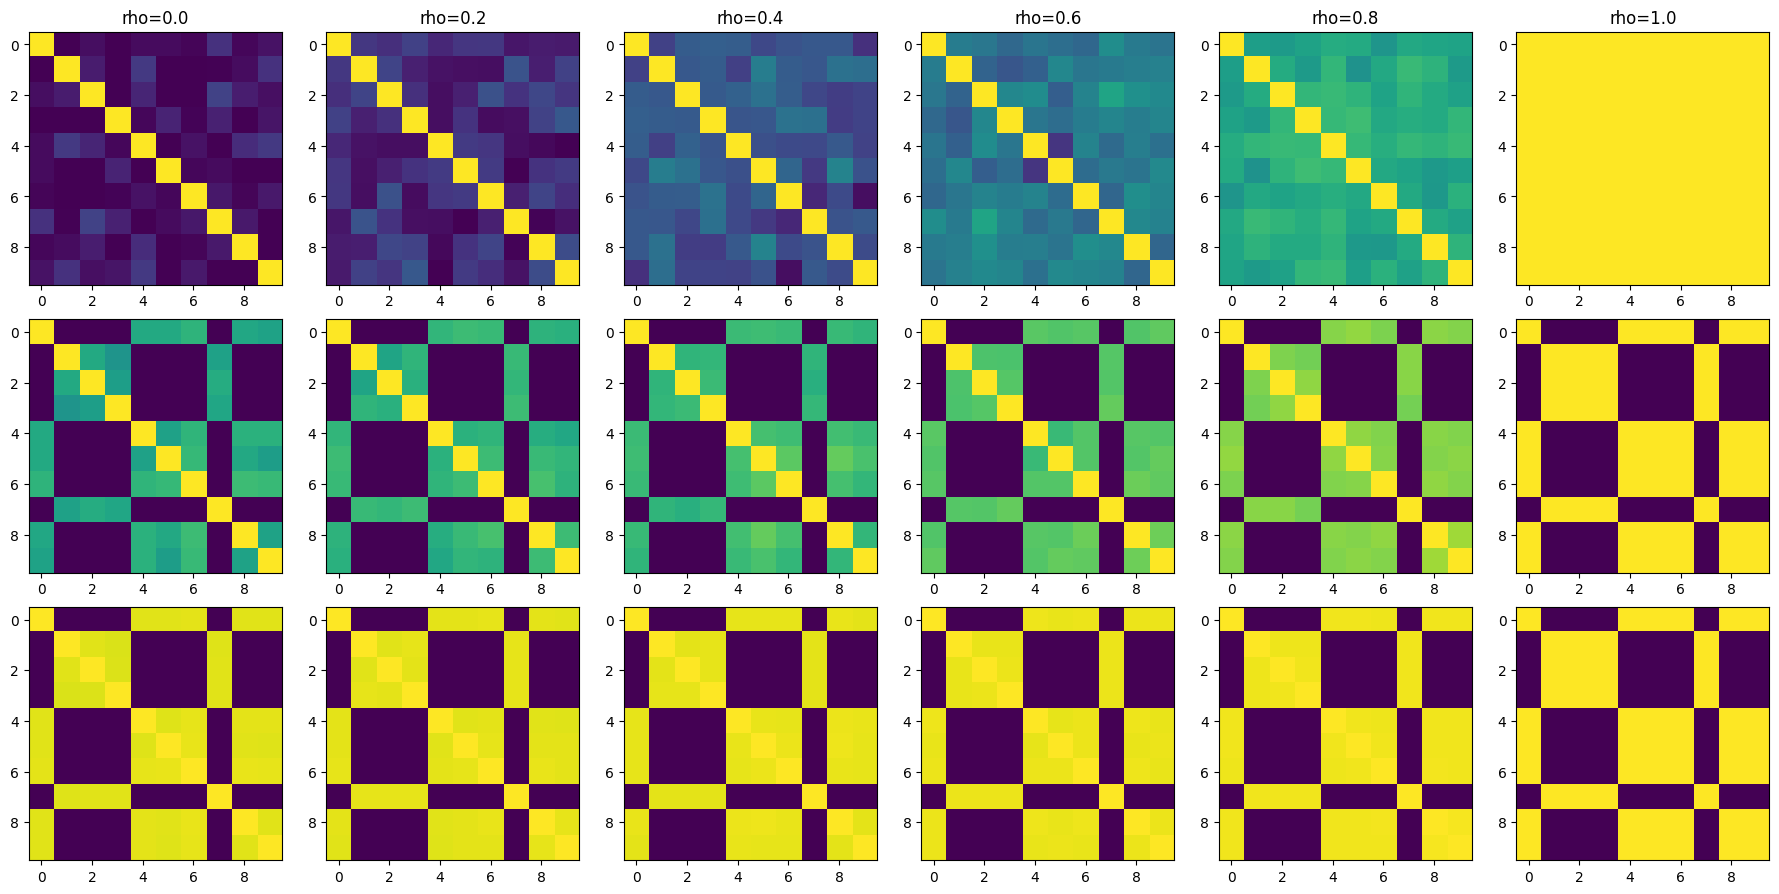

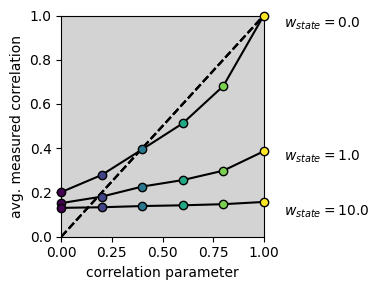

In [80]:
data_seed=0
corrvec=corrs
corr_matrices={}
for wstate in wstates:
    corr_matrices[wstate]={}
    for corr in corrs:
        hashh=data_dir_store[wstate][corr]
        
        actions,pref_actions=get_action_data(hashh,get_pref_actions=True,data_seed=data_seed)

        actions = (actions==pref_actions[np.newaxis,:])
        corr_matrices[wstate][corr]=get_corr_matrix(actions)

# fig, ax = pl.subplots(len(net_names), len(corrvec), figsize=(3*len(net_names), 3*len(corrvec)))
fig, ax = pl.subplots(len(wstates), len(corrs), figsize=(3*(len(corrs)),3*len(wstates)))
figt,axt=pl.subplots(1,1,figsize=(4,3))
# figs,axs=pl.subplots()
colors=pl.cm.get_cmap('viridis')(np.linspace(0,1,len(corrs)))
net_data={}
heights=[1.0,0.4,0.15]
for nit,wstate in enumerate(corr_matrices.keys()):
    
    df=pd.DataFrame(columns=('pcorr','rho'))
    nbins=41
    count_store=np.zeros((len(corrvec),nbins-1))
    means=[]
    stds=[]
    for rit, rho in enumerate(list(corr_matrices[0.].keys())):
        cmtr=corr_matrices[wstate][rho]
        ax[0, rit].set_title(f"rho={rho}")
        ax[nit, rit].imshow(cmtr,vmin=0,vmax=1)
        mask=np.tril(np.ones(cmtr.shape,dtype=bool))
        means.append(np.mean(cmtr[mask]))
        stds.append(np.std(cmtr[mask]))
        counts, bins =np.histogram(cmtr[mask],bins=np.linspace(-1,1,nbins))
        count_store[rit,:]=counts
        # axt[nit,0].bar(bins[:-1],count_store[rit,:],width=0.1,color=colors[rit])

    axt.fill_between(x=corrvec,y1=np.array(means)+np.array(stds),y2=np.array(means)-np.array(stds),color='lightgray')
    axt.plot(corrvec,means,'k-')
    for rit,corr in enumerate(corrvec):
        axt.plot([corr],[means[rit]],'ko',mfc=colors[rit],clip_on=False,zorder=4)
    axt.set_ylabel('avg. measured correlation')
    axt.plot([0,1],[0,1],'k--')
#     sns.lineplot(data=df,ax=axt, x='pcorr',y='rho',errorbar='sd')
#     axt[nit,0].set_xlim(-0.2,1)
    axt.set_ylim(0,1)
    axt.set_xlim(0,1)
    axt.text(1.1, heights[nit], r"$w_{state}=$"+str(wstate), ha='left', va='top', transform=axt.transAxes)



    # ax.set_ylabel(f"w={wstate}")
# axs.plot(net_data['bitpop'],net_data['simple'],'o-')
# axs.plot([0,1],[0,1],'k--')

axt.set_xlabel('correlation parameter')
# axt[1,0].set_xlabel('measured correlation')
# axt[0,0].set_ylabel('count')
# axt[1,0].set_ylabel('count')
# axt[0,0].text(.1, .9, 'bitpop', ha='left', va='top', transform=axt[0,0].transAxes)
# axt[1,0].text(.1, .9, 'simpletask', ha='left', va='top', transform=axt[1,0].transAxes)
figt.savefig('corr.pdf',transparent=None, dpi=300,format='pdf',bbox_inches='tight')
fig.tight_layout()
figt.tight_layout()
# axt.set_ylim(0,1)